/home/edu/miniconda3/envs/causal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


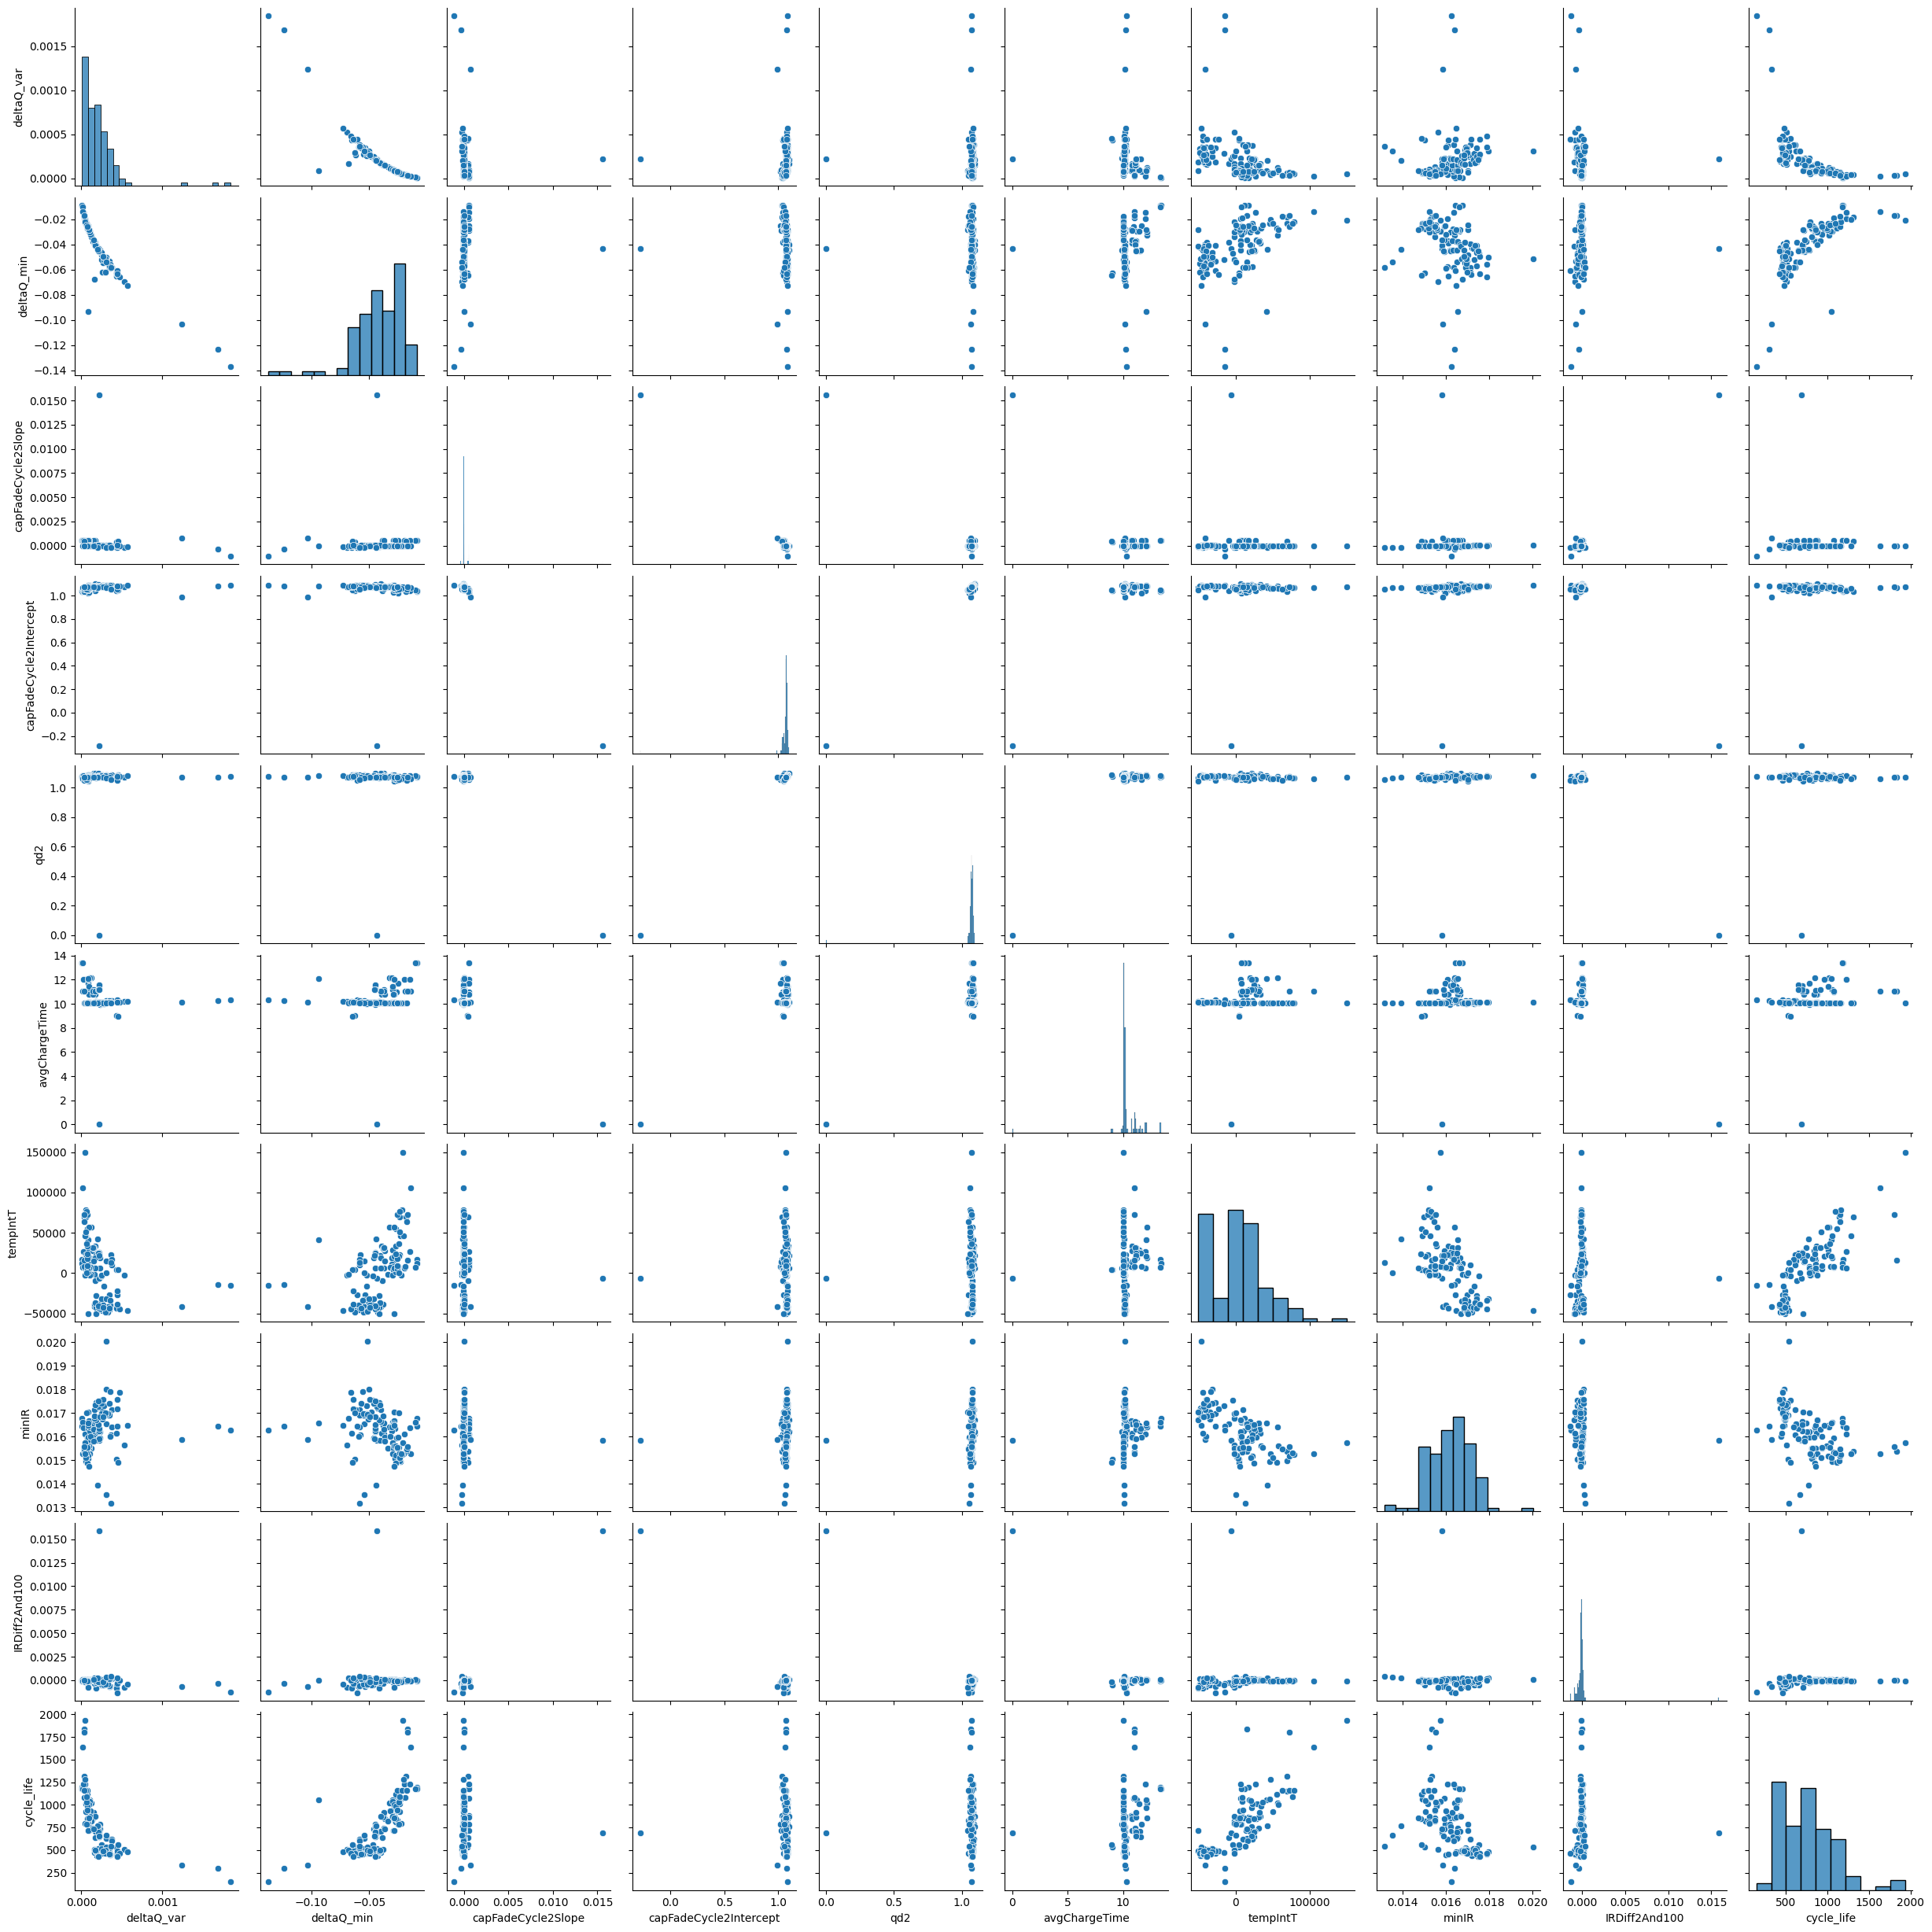

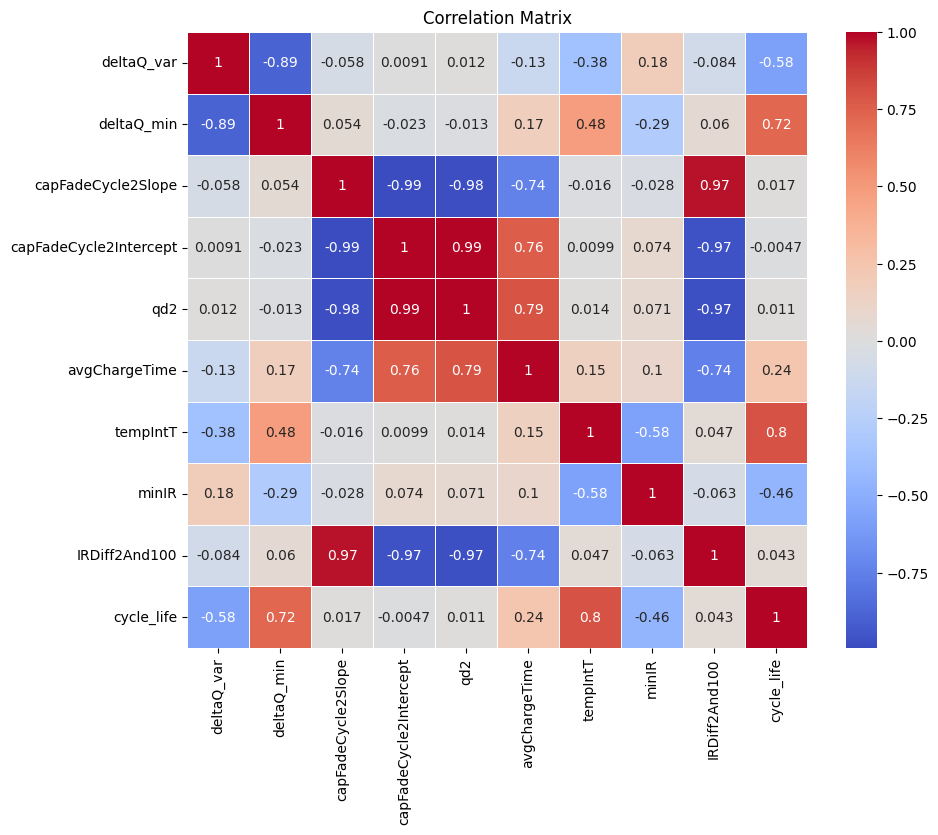

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import shap

warnings.filterwarnings("ignore")


data = pd.read_csv("BatteryFeatures.csv")
#Y = data["cycle_life"]
#data = data.drop(columns=['cycle_life'])

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the pairplot
sns.pairplot(data)
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

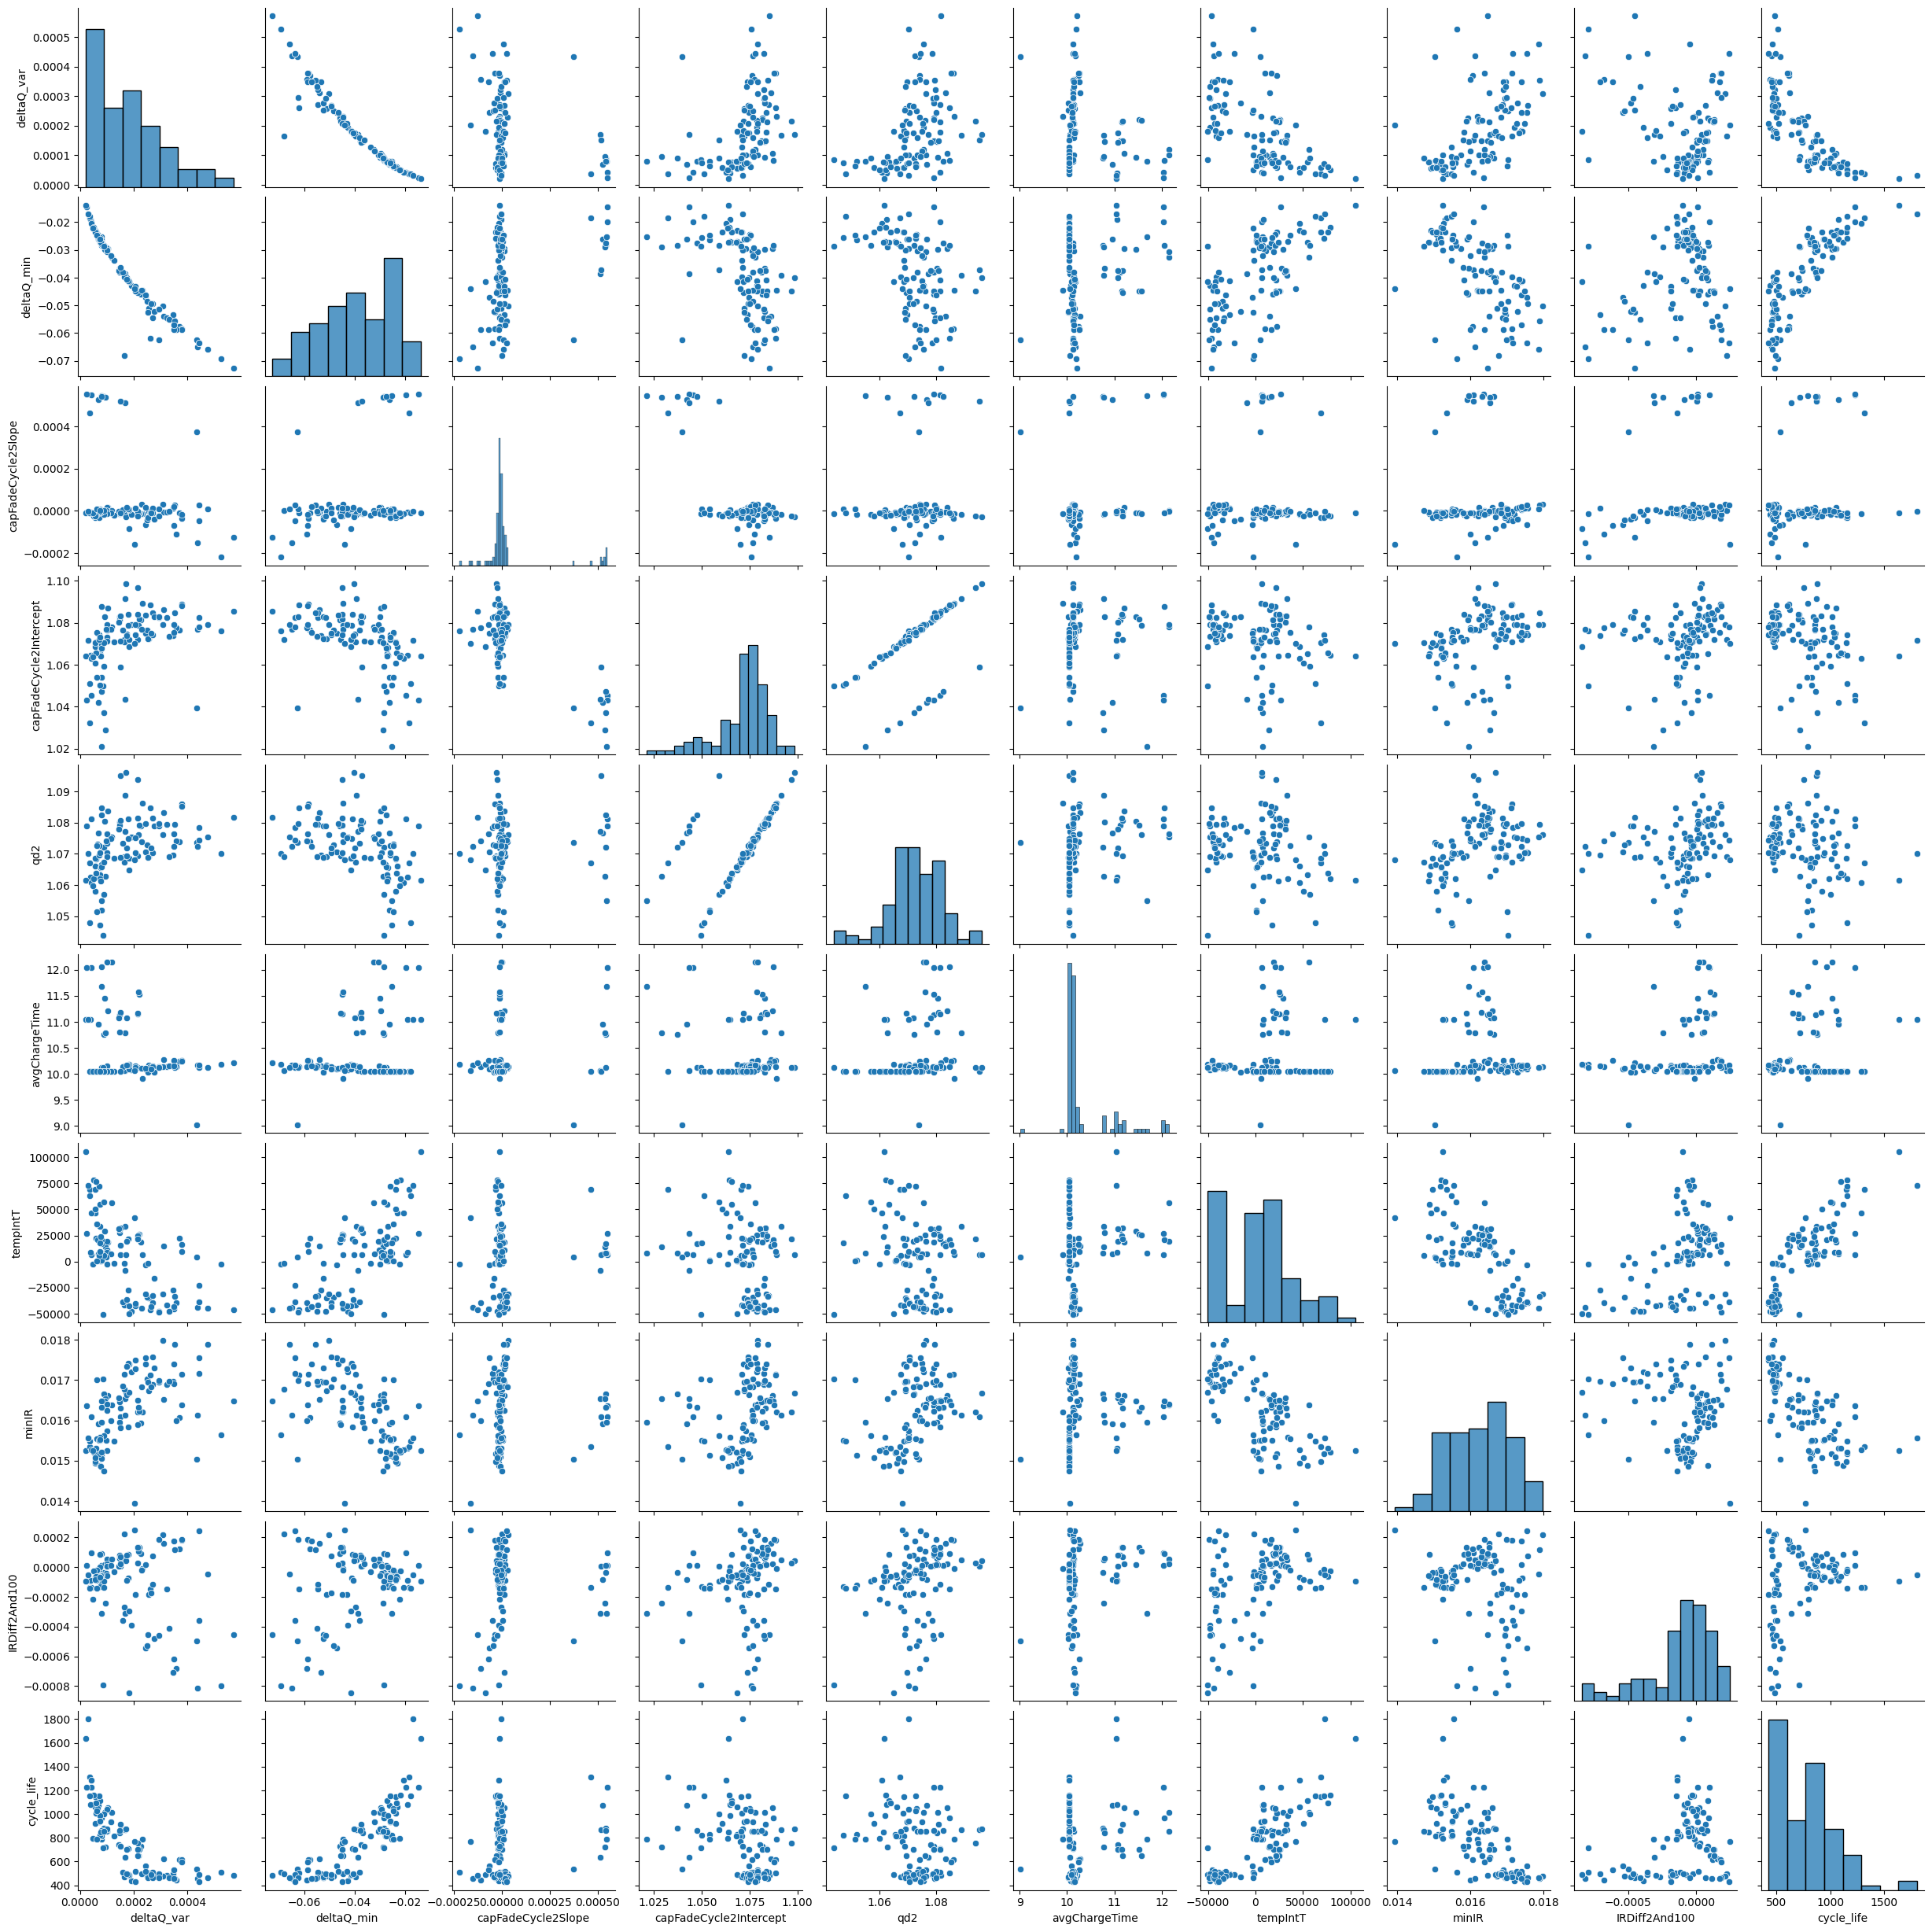

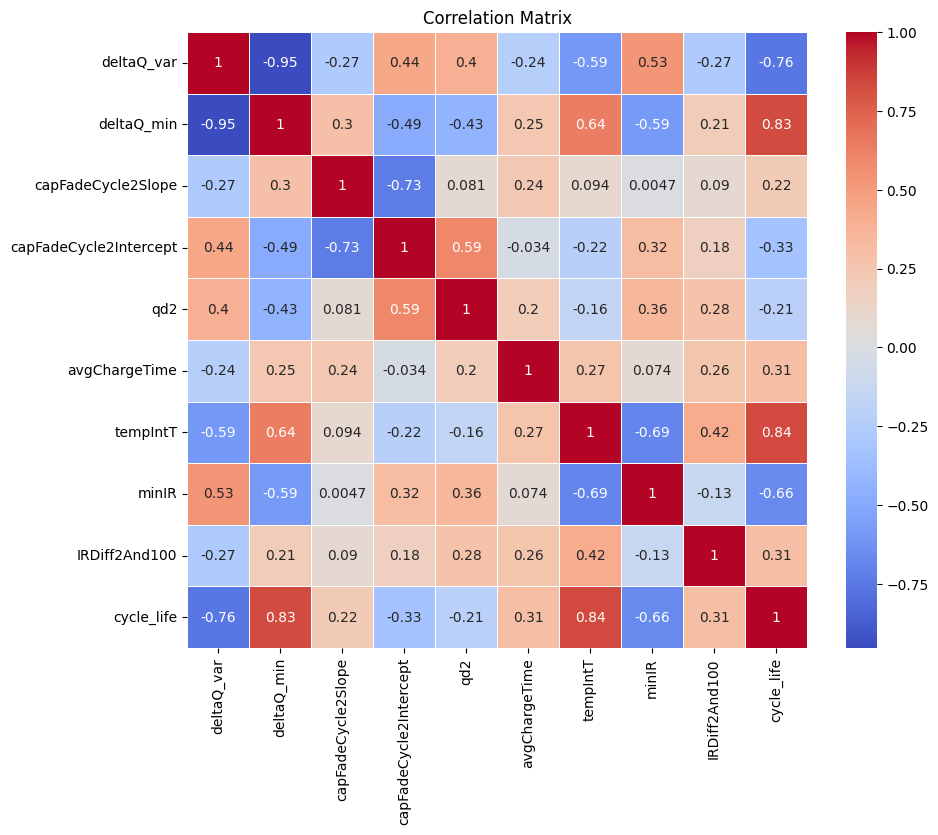

In [2]:
def remove_outliers_chi_squared(df, significance_level=0.05):
    # Calculate the chi-squared critical value
    chi_squared_critical_value = chi2.ppf(1 - significance_level, df.shape[1])
    
    # Calculate the Mahalanobis distance for each row
    mean = np.mean(df, axis=0)
    cov = np.cov(df.values, rowvar=False)
    inv_covmat = np.linalg.inv(cov)
    mahalanobis_distances = df.apply(lambda row: np.dot(np.dot((row - mean), inv_covmat), (row - mean).T), axis=1)
    
    # Identify outliers
    outliers = mahalanobis_distances > chi_squared_critical_value
    
    # Remove outliers
    cleaned_df = df[~outliers]
    
    return cleaned_df

# Apply the function to remove outliers from the dataset
cleaned_data = remove_outliers_chi_squared(data)

# Calculate the correlation matrix
correlation_matrix_clean = cleaned_data.corr()

# Plot the pairplot
sns.pairplot(cleaned_data)
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_clean, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [3]:
# Split data into interest variable and mined patters
cycle_life = cleaned_data["cycle_life"]
cleaned_data = cleaned_data.drop(columns=['cycle_life'])

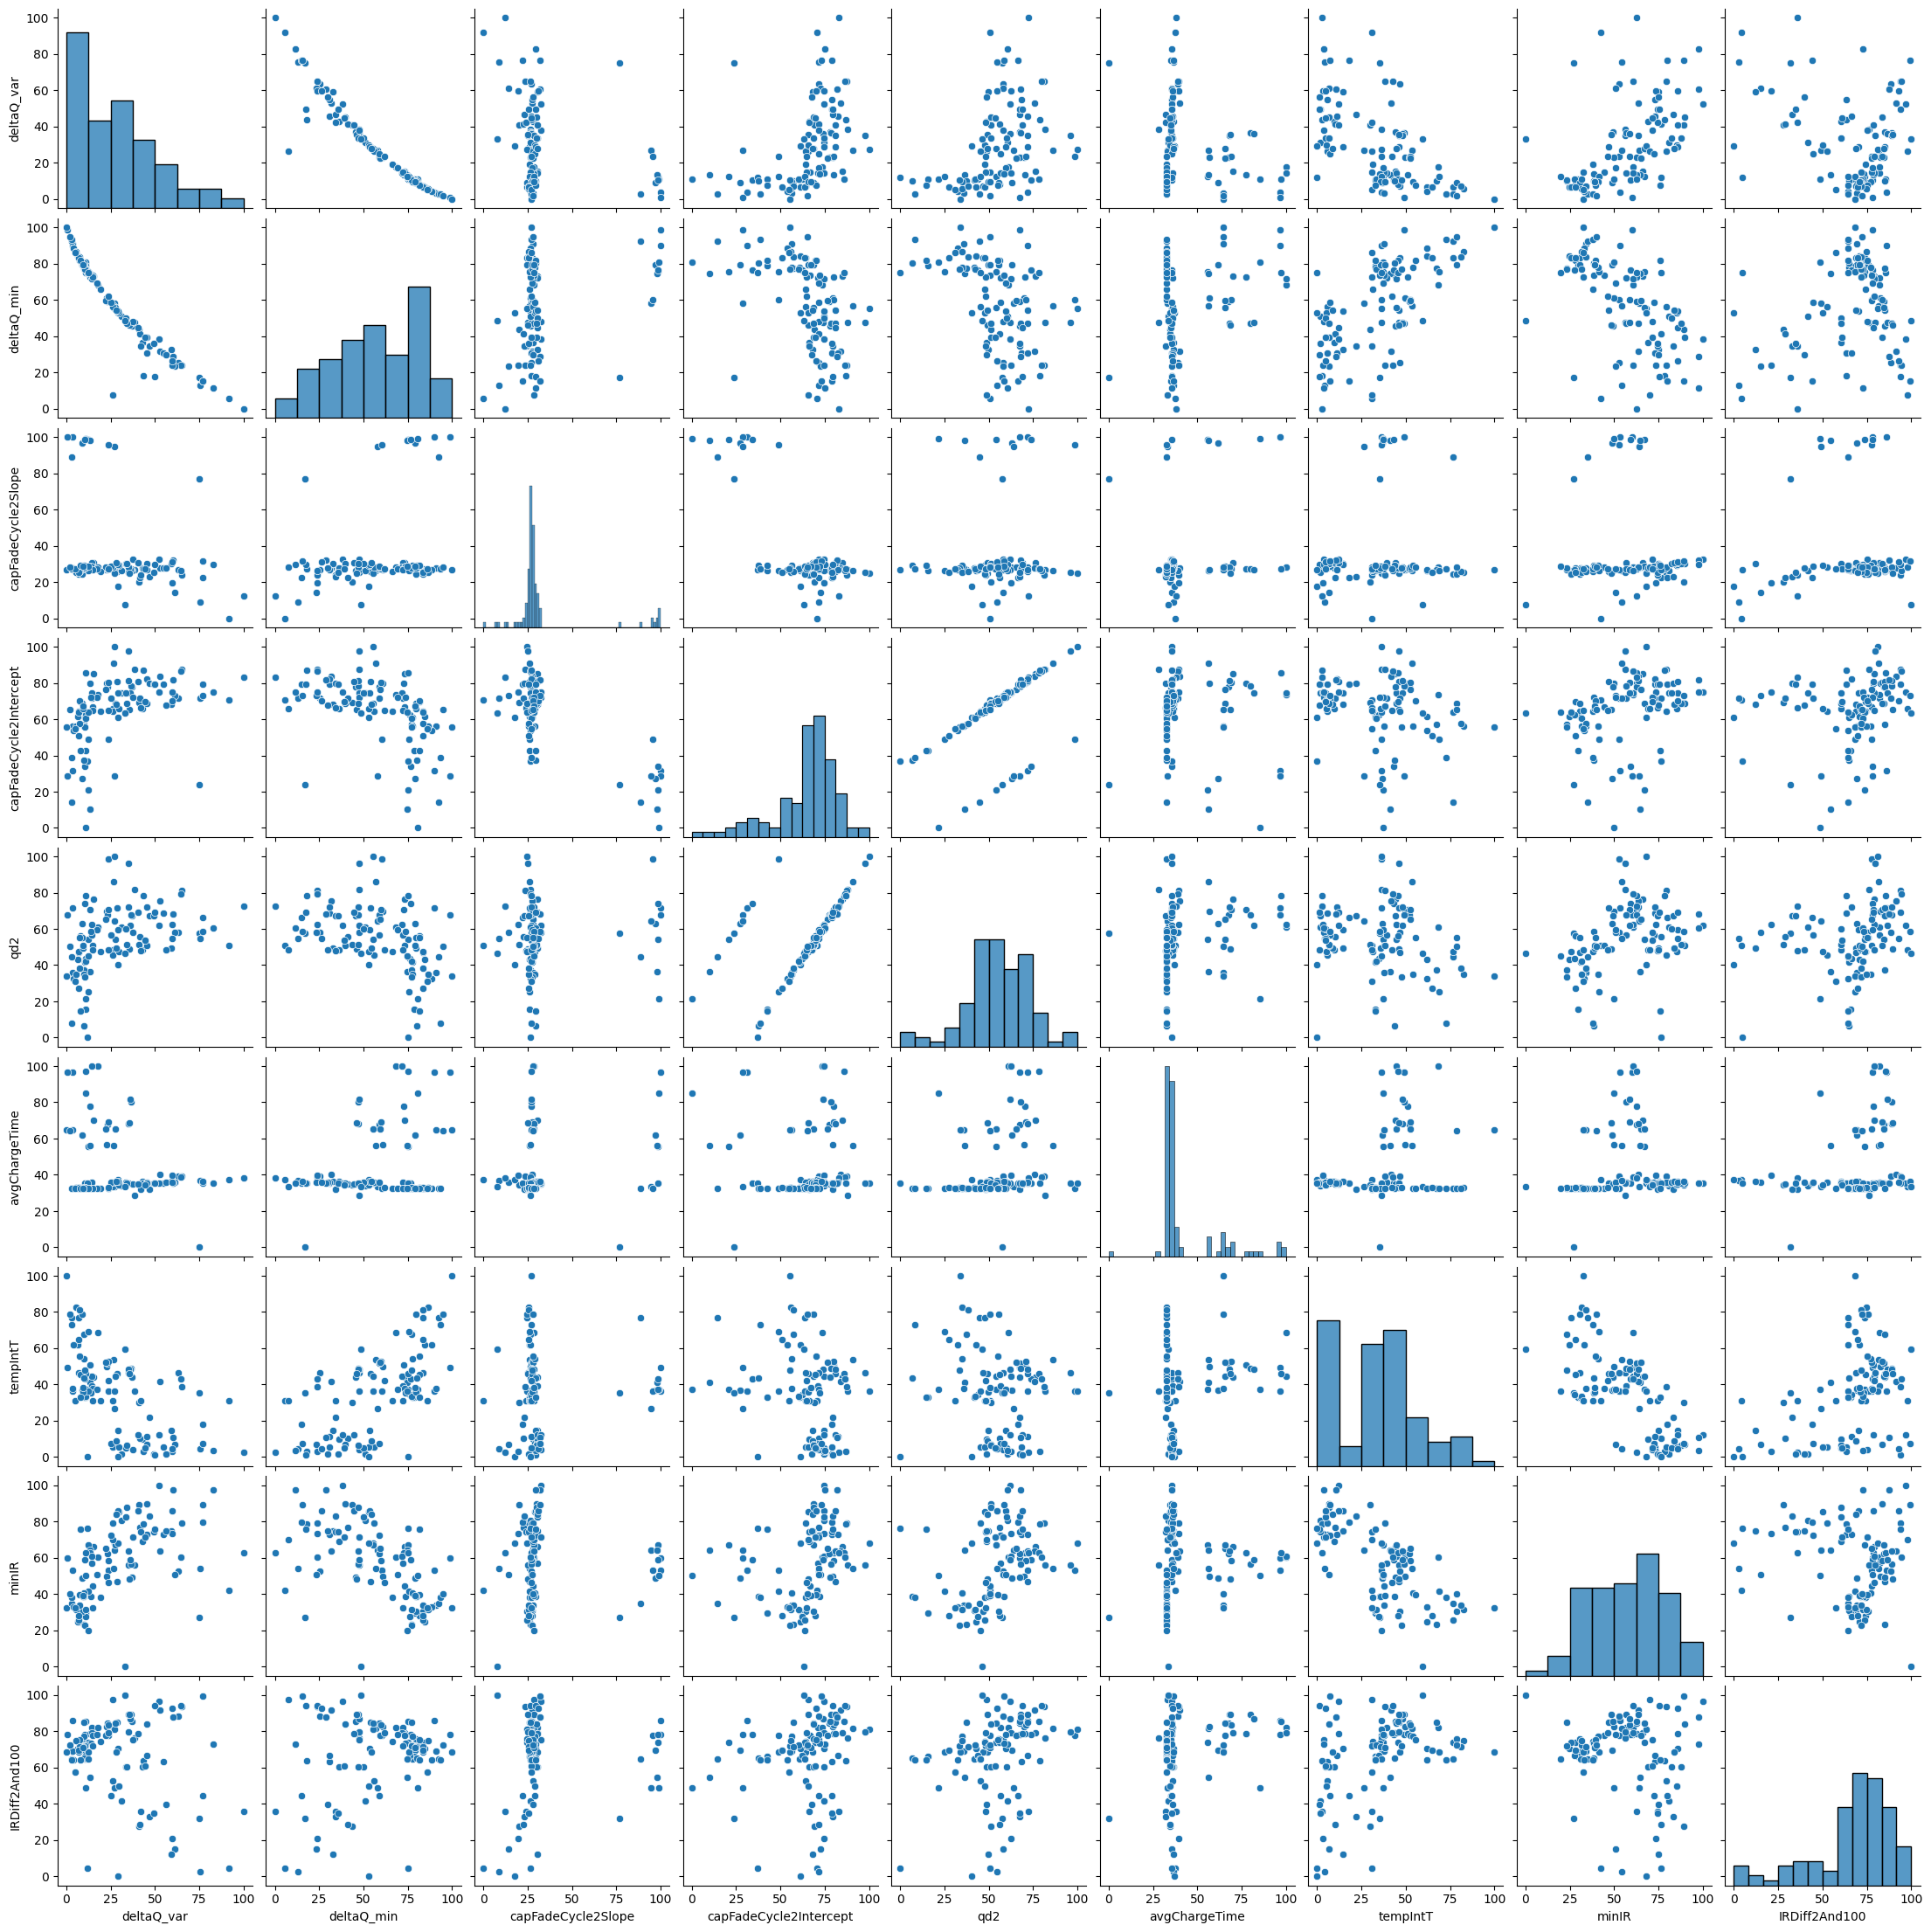

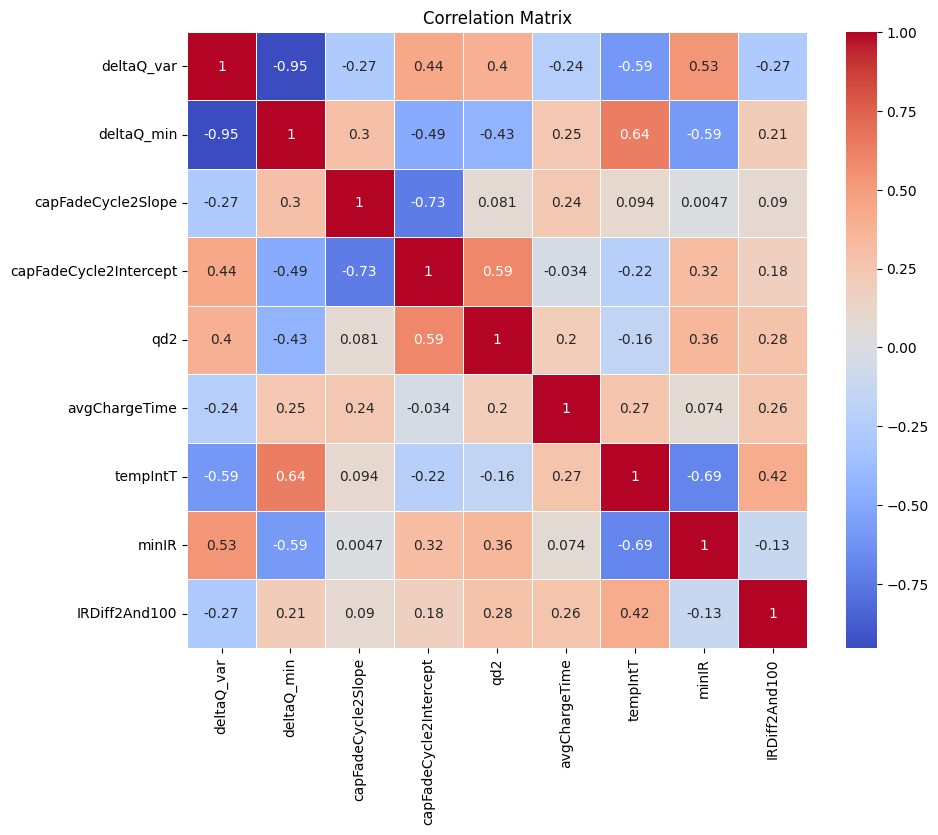

In [4]:
def normalize_data(df):
    scaler = MinMaxScaler(feature_range=(0, 100))
    normalized_data = scaler.fit_transform(df)
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)
    return normalized_df

# Apply the normalization function to the cleaned dataset
normalized_data = normalize_data(cleaned_data)

correlation_matrix_normal = normalized_data.corr()

# Plot the pairplot
sns.pairplot(normalized_data)
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_normal, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [5]:
def normalized_root_mean_squared_error(original, reconstructed):
        mse = mean_squared_error(original, reconstructed)
        rmse = np.sqrt(mse)
        norm_rmse = rmse / (np.max(original) - np.min(original))
        return norm_rmse
    

In [6]:
def discretize_data_with_lower_bounds(df, bins=100):
    discretized_df = pd.DataFrame()
    for col in df.columns:
        # Get the bin edges
        bin_edges = np.linspace(df[col].min(), df[col].max(), bins + 1)
            
        # Assign each value to the lower bound of its bin
        bin_labels = bin_edges[:-1]
        discretized_col = pd.cut(df[col], bins=bin_edges, labels=bin_labels, include_lowest=True)
            
        discretized_df[col] = discretized_col.astype(float)
        
    return discretized_df

In [7]:
def plot_quality_vs_complexity(normalized_data):

    loss_array = []
    D_array = []
    num_bins_max = 100

    for bins in range(1,num_bins_max + 1):

        discretized_data = discretize_data_with_lower_bounds(normalized_data,bins = bins)
        
        #loss = normalized_root_mean_squared_error(normalized_data, discretized_data)
        loss = np.linalg.norm(normalized_data - discretized_data,1)
    
        unique_values = {col: discretized_data[col].unique() for col in discretized_data.columns}
        
        D = 0
        
        for i in unique_values:
            D += len(unique_values[i])

        loss_array.append(loss)
        D_array.append(D)

    D_array = np.array(D_array)
    loss_array = np.array(loss_array)
    
    #D_array = D_array / np.max(D_array)
    #loss_array = loss_array / np.max(loss_array)

    return D_array,loss_array

D_array,loss_array = plot_quality_vs_complexity(normalized_data)

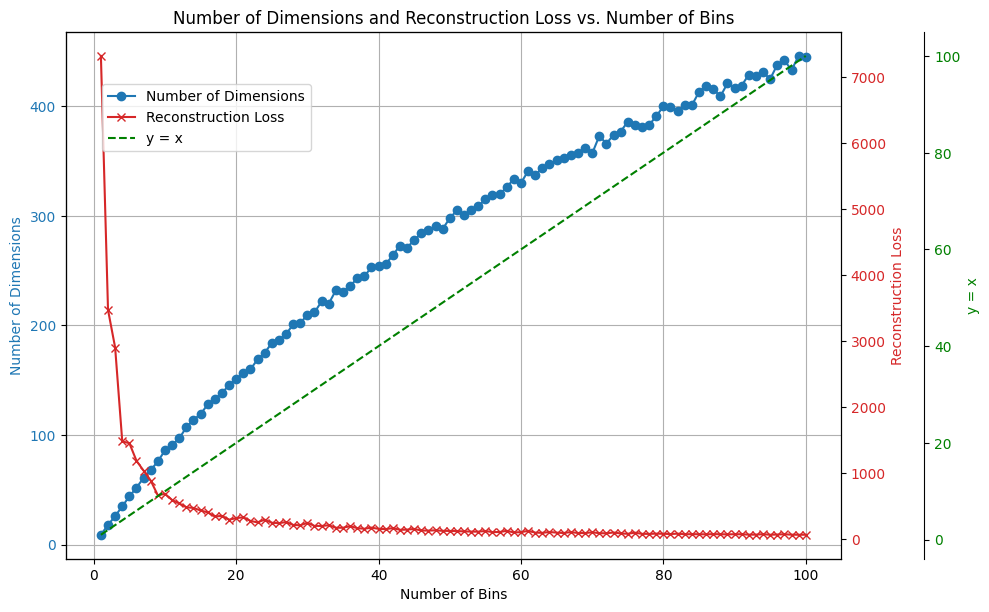

In [8]:
bins = [i for i in range(1,101)]

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for the number of dimensions
ax1.set_xlabel('Number of Bins')
ax1.set_ylabel('Number of Dimensions', color='tab:blue')
ax1.plot(bins, D_array, label='Number of Dimensions', color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create a second y-axis for the reconstruction loss
ax2 = ax1.twinx()
ax2.set_ylabel('Reconstruction Loss', color='tab:red')
ax2.plot(bins, loss_array, label='Reconstruction Loss', color='tab:red', marker='x')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Plot y = x line
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third axis outwards
ax3.plot(bins, bins, label='y = x', color='green', linestyle='--')
ax3.set_ylabel('y = x', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Add legends
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('Number of Dimensions and Reconstruction Loss vs. Number of Bins')
plt.show()


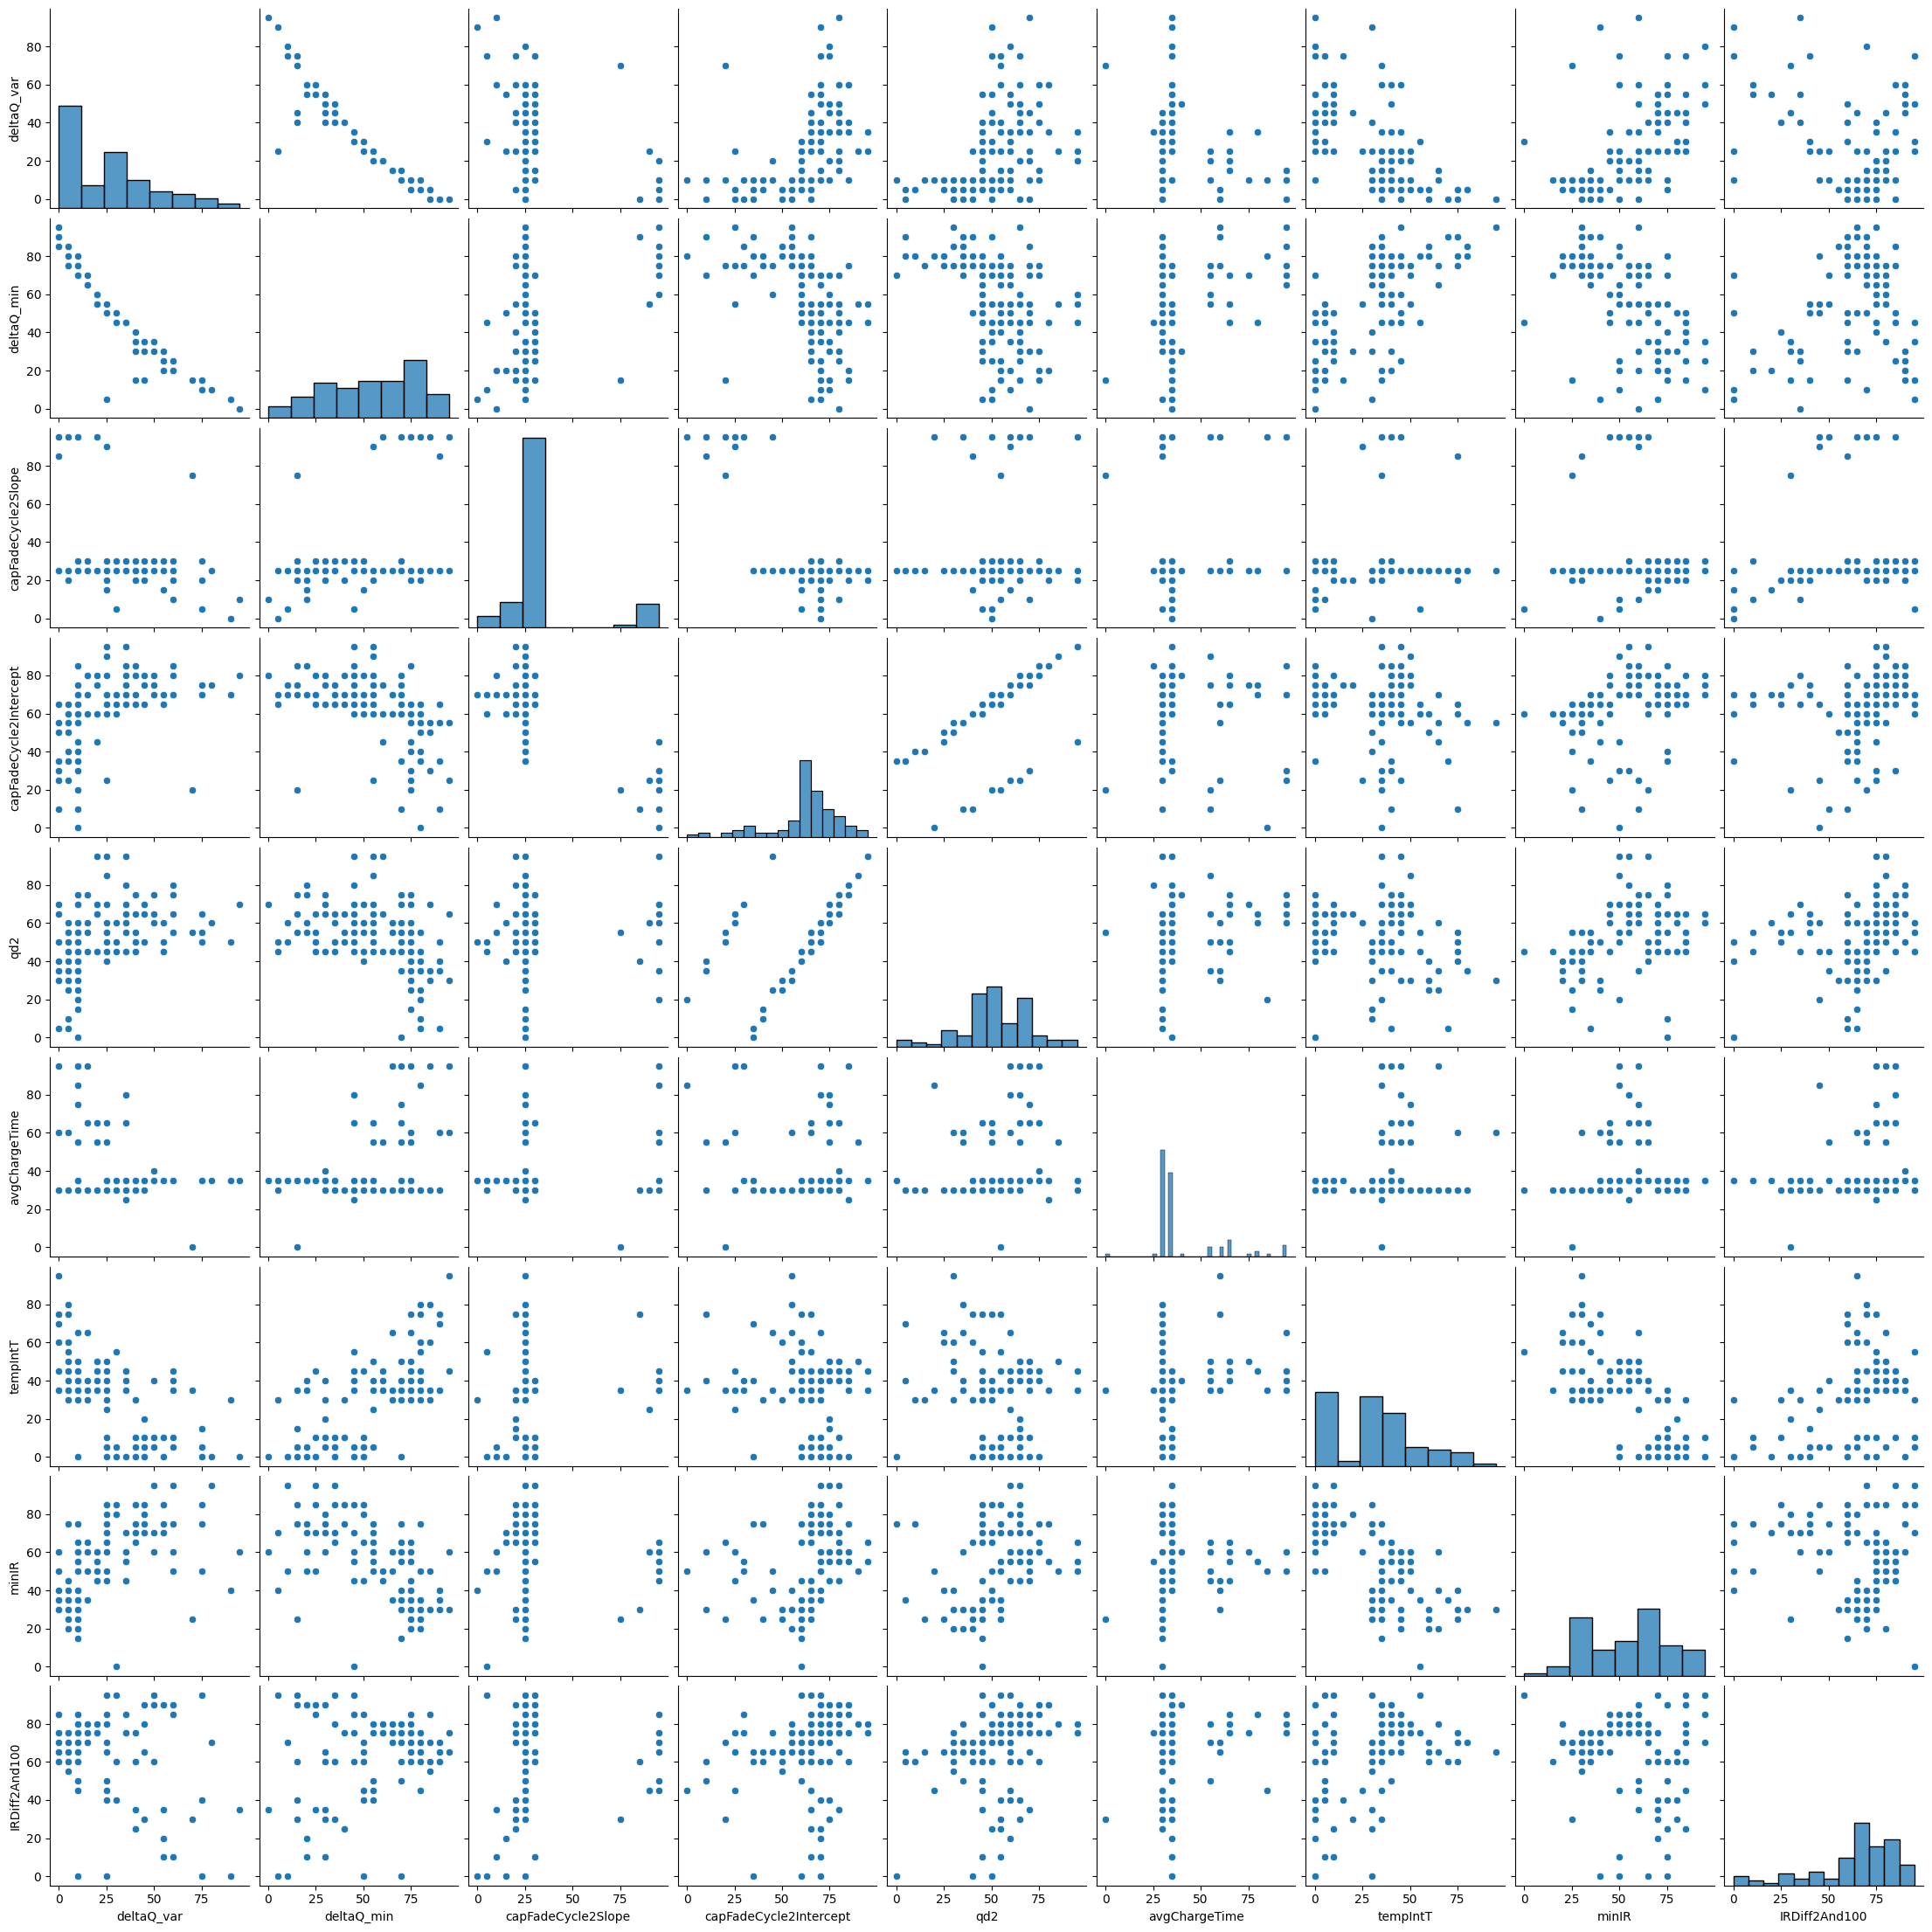

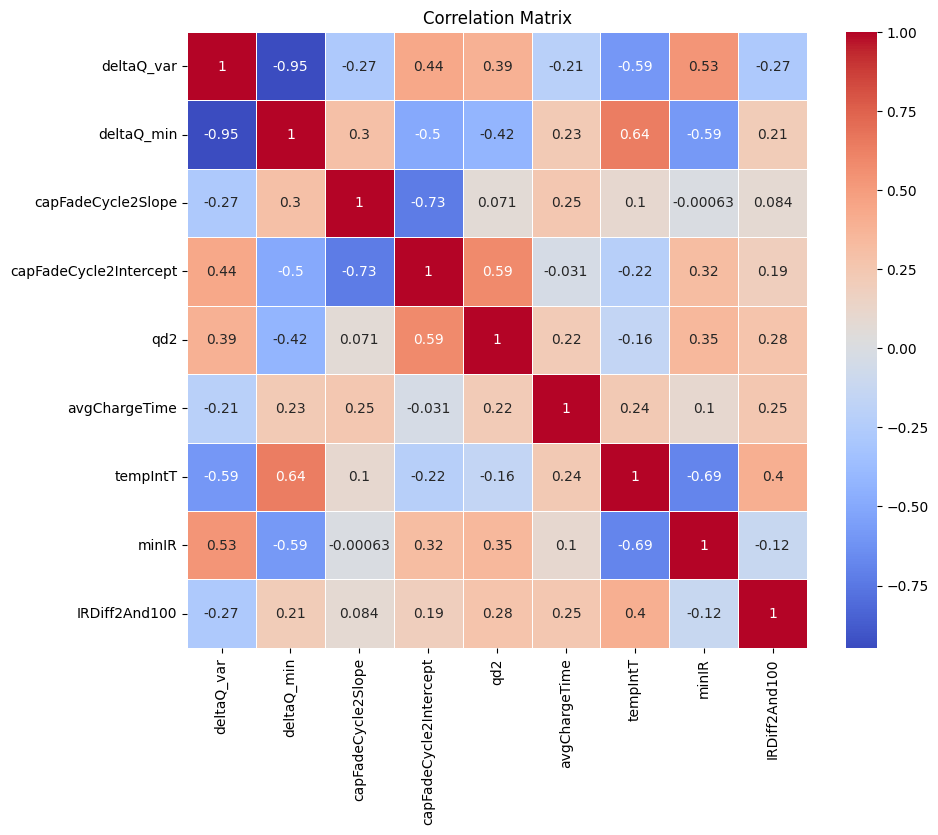

In [9]:
# Apply the discretization function to the normalized dataset
discretized_data = discretize_data_with_lower_bounds(normalized_data,bins = 20)

correlation_matrix_discrete = discretized_data.corr()

# Plot the pairplot
sns.pairplot(discretized_data)
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_discrete, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [10]:
def binarize_columns(df):
    binary_dict = {}
    
    for col in df.columns:
        # Round the values to the nearest integer
        rounded_col = df[col].round().astype(int)
        unique_values = sorted(rounded_col.unique())
        
        for value in unique_values:
            binary_dict[f'{col}_{value}'] = (rounded_col == value).astype(int)
    
    binary_df = pd.DataFrame(binary_dict)
    
    return binary_df

# Example usage
# Assuming discretized_data_with_bounds is your DataFrame
binarized_data = binarize_columns(discretized_data)
binarized_data.head()

,deltaQ_var_0,deltaQ_var_5,deltaQ_var_10,deltaQ_var_15,deltaQ_var_20,deltaQ_var_25,deltaQ_var_30,deltaQ_var_35,deltaQ_var_40,deltaQ_var_45,...,IRDiff2And100_50,IRDiff2And100_55,IRDiff2And100_60,IRDiff2And100_65,IRDiff2And100_70,IRDiff2And100_75,IRDiff2And100_80,IRDiff2And100_85,IRDiff2And100_90,IRDiff2And100_95
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [11]:
"""
To do:
1) Implementar processo inverso: temos um vetor binario de atributos, agora temos que voltar para a representacao em bins, depois basta fazer a representacao em intervalos para interpretar os grupos.
2) Implementar o algoritmo de mineracao SSD++
3) Verificar o processo 
"""

'\nTo do:\n1) Implementar processo inverso: temos um vetor binario de atributos, agora temos que voltar para a representacao em bins, depois basta fazer a representacao em intervalos para interpretar os grupos.\n2) Implementar o algoritmo de mineracao SSD++\n3) Verificar o processo \n'

In [12]:
from mlxtend.frequent_patterns import fpgrowth

def generate_frequent_itemsets(data, min_support=0.1):
    """
    Generate frequent itemsets using the FP-Growth algorithm.
    """
    frequent_itemsets = fpgrowth(data, min_support=min_support, use_colnames=True)
    return frequent_itemsets

def evaluate_itemsets(data, target, itemsets):
    """
    Evaluate the interestingness of each itemset.
    """
    evaluations = []
    for _, row in itemsets.iterrows():
        columns = row['itemsets']
        mask = np.ones(len(data), dtype=bool)
        for col in columns:
            mask &= (data[col] == 1)
        mask = mask.values
        subgroup_data = target[mask]
        if len(subgroup_data) > 0:
            score = subgroup_data.mean()  # Use mean target value as score
            evaluations.append((columns, score))
    return evaluations

def select_best_itemsets(evaluations, top_n=5):
    """
    Select the top N most interesting itemsets.
    """
    evaluations.sort(key=lambda x: x[1], reverse=True)
    return evaluations[:top_n]

def sd_map(X, Y, min_support=0.1, top_n=5, max_iterations=10):
    """
    SD-Map algorithm implementation for binary attributes using FP-Growth.
    Input:
        X     - Dataset (pandas DataFrame) with binary attributes
        Y     - Target variable (pandas Series)
        min_support - Minimum support for the FP-Growth algorithm
        top_n - Number of top itemsets to select
        max_iterations - Maximum number of iterations
    Output:
        discovered_subgroups - List of discovered subgroups
    """
    discovered_subgroups = []
    for _ in range(max_iterations):
        itemsets = generate_frequent_itemsets(X, min_support=min_support)
        if itemsets.empty:
            break
        evaluations = evaluate_itemsets(X, Y, itemsets)
        best_itemsets = select_best_itemsets(evaluations, top_n)
        if not best_itemsets:
            break
        discovered_subgroups.extend(best_itemsets)
        for columns, _ in best_itemsets:
            mask = np.ones(len(X), dtype=bool)
            for col in columns:
                mask &= (X[col] == 1)
            mask = mask.values
            X = X[~mask].reset_index(drop=True)
            Y = Y[~mask].reset_index(drop=True)
    return discovered_subgroups

binarized_data = binarized_data.astype(bool)
subgroups = sd_map(binarized_data, cycle_life, min_support=0.05, top_n=5, max_iterations=10)

In [13]:
def create_subgroup_dataset(X, discovered_subgroups):
    """
    Create a new dataset where each attribute indicates membership in a subgroup.
    """
    new_data = pd.DataFrame(index=X.index)
    
    for i, (subgroup, _) in enumerate(discovered_subgroups):
        new_col = np.ones(len(X), dtype=bool)
        for attr in subgroup:
            new_col &= (X[attr] == 1)
        new_data[f'Subgroup_{i}'] = new_col.astype(int)
    
    return new_data

In [14]:
(binarized_data.sum()).sum()/((binarized_data.shape[0])*(binarized_data.shape[1]))

0.059602649006622516

In [15]:
new_X = create_subgroup_dataset(binarized_data, subgroups)

In [16]:
(new_X.sum()).sum()/((new_X.shape[0])*(new_X.shape[1]))

0.06256880733944954

In [17]:
X = discretized_data
Y = cycle_life

In [18]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, Y_train)

# Predict using the model
Y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Display the feature importances
print("Feature Importances:", model.feature_importances_)

Mean Squared Error: 9234.137372116727
R^2 Score: 0.8253677908171773
Feature Importances: [0.6416167  0.00660273 0.00755584 0.0301853  0.01512141 0.0172033
 0.2646937  0.00349979 0.01352119]


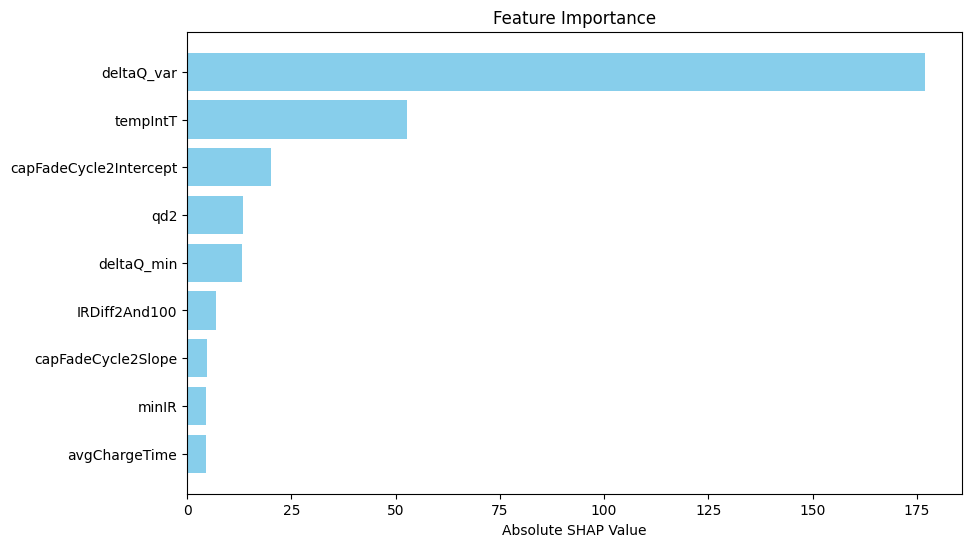

Feature Importance:
                  Feature  Importance
0              deltaQ_var  177.002882
6                tempIntT   52.814543
3  capFadeCycle2Intercept   20.160672
4                     qd2   13.346848
1              deltaQ_min   13.179184
8           IRDiff2And100    6.874785
2      capFadeCycle2Slope    4.863331
7                   minIR    4.535939
5           avgChargeTime    4.485840


In [19]:
# Calculate Shapley values using the shap library
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Compute the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": mean_abs_shap_values
}).sort_values(by="Importance", ascending=False)

# Plot the mean absolute SHAP values
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute SHAP Value')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

print("Feature Importance:")
print(importance_df)

In [20]:
cut_importance = np.min((importance_df.values).T[1])
cut_importance

4.4858398383517235

In [21]:
X = new_X
Y = cycle_life

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, Y_train)

# Predict using the model
Y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Display the feature importances
print("Feature Importances:", model.feature_importances_)

Mean Squared Error: 28609.4700627211
R^2 Score: 0.45894946552462246
Feature Importances: [2.8210929e-01 7.4250125e-03 0.0000000e+00 2.4320369e-03 2.5147659e-04
 1.7418056e-03 0.0000000e+00 2.9031333e-01 2.7769157e-03 0.0000000e+00
 2.3521387e-04 9.4934337e-02 1.3552260e-03 2.9481519e-03 0.0000000e+00
 9.0878422e-04 0.0000000e+00 8.4820222e-03 0.0000000e+00 4.4559482e-03
 2.5251124e-03 9.3057868e-04 0.0000000e+00 0.0000000e+00 4.9748637e-02
 1.7415595e-01 1.3659233e-02 5.0030039e-03 1.1015129e-02 0.0000000e+00
 7.5168749e-03 4.5675160e-03 6.9922395e-03 1.2883535e-04 1.5619172e-03
 4.0726759e-03 7.3056924e-03 1.4731585e-04 5.3812121e-04 0.0000000e+00
 6.3583069e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.1584474e-04 7.9756109e-03 2.9468304e-04 1.3965560e-04 0.0000000e+00]


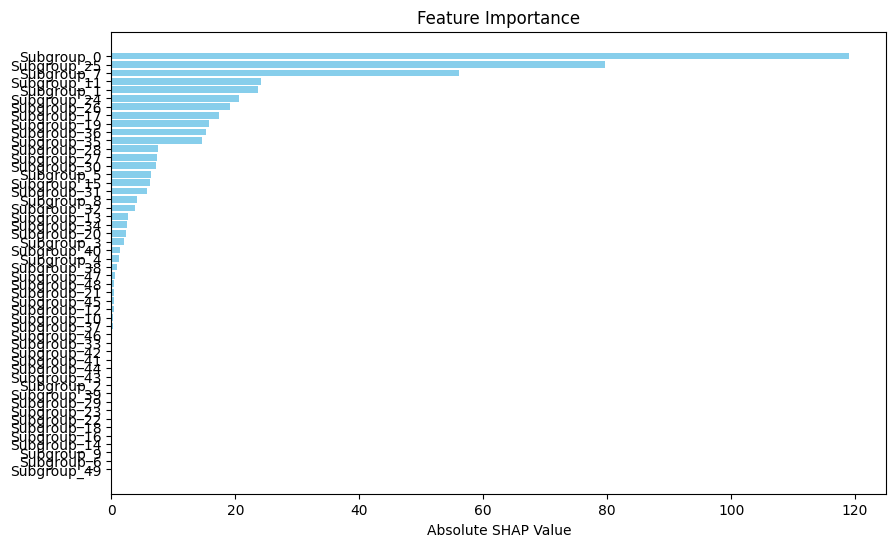

Feature Importance:
        Feature  Importance
0    Subgroup_0  119.089354
25  Subgroup_25   79.664545
7    Subgroup_7   56.137604
11  Subgroup_11   24.134411
1    Subgroup_1   23.601888
24  Subgroup_24   20.638213
26  Subgroup_26   19.116986
17  Subgroup_17   17.347639
19  Subgroup_19   15.722868
36  Subgroup_36   15.351075
35  Subgroup_35   14.702450
28  Subgroup_28    7.568621
27  Subgroup_27    7.305758
30  Subgroup_30    7.281653
5    Subgroup_5    6.317465
15  Subgroup_15    6.299789
31  Subgroup_31    5.742063
8    Subgroup_8    4.203573
32  Subgroup_32    3.776897
13  Subgroup_13    2.734517
34  Subgroup_34    2.539951
20  Subgroup_20    2.407591
3    Subgroup_3    2.076868
40  Subgroup_40    1.327811
4    Subgroup_4    1.265953
38  Subgroup_38    0.840076
47  Subgroup_47    0.536492
48  Subgroup_48    0.483707
21  Subgroup_21    0.411266
45  Subgroup_45    0.406346
12  Subgroup_12    0.361487
10  Subgroup_10    0.345152
37  Subgroup_37    0.285320
46  Subgroup_46    0.164591


In [22]:
# Calculate Shapley values using the shap library
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Compute the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": mean_abs_shap_values
}).sort_values(by="Importance", ascending=False)

# Plot the mean absolute SHAP values
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute SHAP Value')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

print("Feature Importance:")
print(importance_df)

In [23]:
important_features = importance_df[importance_df['Importance'] > cut_importance]
important_features

,Feature,Importance
0,Subgroup_0,119.089354
25,Subgroup_25,79.664545
7,Subgroup_7,56.137604
11,Subgroup_11,24.134411
1,Subgroup_1,23.601888
24,Subgroup_24,20.638213
26,Subgroup_26,19.116986
17,Subgroup_17,17.347639
19,Subgroup_19,15.722868
36,Subgroup_36,15.351075


In [30]:
(important_features.Importance).mean()

26.236610536680995

In [31]:
import numpy as np

def transition_fn(state, X, visited):
    n_samples, n_features = X.shape
    transitions = []
    
    # For each feature not in the current state, add it to the state
    for feature_idx in range(n_features):
        if feature_idx not in state:
            new_state = state + [feature_idx]
            new_state_tuple = tuple(sorted(new_state))
            
            if new_state_tuple not in visited and len(new_state) < n_features:
                transitions.append((feature_idx, new_state))
                visited.add(new_state_tuple)
    
    return transitions

def score_fn(state, X, Y):
    if len(state) == 0:
        return 0
    
    mask = np.all(X[:, state] == 1, axis=1)
    Y_subset = Y[mask]
    
    if len(Y_subset) == 0:
        return 0
    
    return np.mean(Y_subset)

def beam_search(start, transition_fn, score_fn, beam_width, max_len, max_iter, X, Y):
    # Initialize the beam with the start state
    beam = [(start, [], 0)]
    visited = set()
    visited.add(tuple(start))
    
    # Initialize M with an empty subset and its score
    M = []
    M_score = 0
    iteration = 0
    
    while iteration < max_iter:
        iteration += 1
        candidates = []
        
        # Generate new candidates by expanding each current candidate
        for state, seq, score in beam:
            for action, next_state in transition_fn(state, X, visited):
                new_seq = seq + [action]
                new_score = score_fn(next_state, X, Y)
                delta = new_score - M_score
                if delta > 0:
                    candidates.append((next_state, new_seq, new_score, delta))
        
        if not candidates:
            break
        
        # Select the top `beam_width` candidates based on their positive deltas
        candidates = sorted(candidates, key=lambda x: x[3], reverse=True)[:beam_width]
        
        # Update M and M_score
        for candidate in candidates:
            _, _, candidate_score, _ = candidate
            M.append(candidate)
            M_score = np.mean([score for _, _, score, _ in M])
        
        # Update the beam with the new candidates
        beam = [(next_state, new_seq, new_score) for next_state, new_seq, new_score, _ in candidates]
    
    # Return the subsets in M and their associated values
    return [(subgroup[1], subgroup[2]) for subgroup in M]

X = binarized_data.values
Y = cycle_life.values

beam_width = 150
max_len = X.shape[1]
max_iter = 100000
start_state = []

M_result = beam_search(start_state, transition_fn, score_fn, beam_width, max_len, max_iter, X, Y)



In [32]:
def build_binary_dataset(subgroups, X):
    n_samples = X.shape[0]
    n_subgroups = len(subgroups)
    
    binary_dataset = np.zeros((n_samples, n_subgroups), dtype=int)
    
    for idx, subgroup in enumerate(subgroups):
        state = subgroup[0]
        mask = np.all(X[:, state] == 1, axis=1)
        binary_dataset[:, idx] = mask.astype(int)
    
    return binary_dataset

X_new = build_binary_dataset(M_result, X)

In [33]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, Y_train)

# Predict using the model
Y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Display the feature importances
print("Feature Importances:", model.feature_importances_)

Mean Squared Error: 28249.741020584184
R^2 Score: 0.4657525132597884
Feature Importances: [4.41203156e-06 1.14225088e-06 8.81027244e-03 3.72327329e-03
 1.93200290e-01 0.00000000e+00 1.40634970e-08 5.17224707e-03
 4.02950915e-03 3.42575926e-03 7.73425927e-06 1.00135815e-03
 2.40553891e-05 1.85475417e-03 4.31089749e-04 1.79703406e-04
 8.48339871e-03 3.70778479e-02 1.18552719e-03 3.71874671e-06
 4.80144372e-04 3.45209904e-04 1.10117707e-03 4.90825586e-02
 2.81423051e-03 1.91120236e-07 3.72107810e-04 3.36493429e-07
 1.80865172e-03 3.58296223e-02 3.90716945e-04 2.65777647e-03
 1.03001192e-04 0.00000000e+00 4.35959257e-04 1.08352462e-04
 1.38645072e-03 4.85934410e-03 0.00000000e+00 5.96493541e-04
 2.67092673e-06 7.62783573e-04 8.78065184e-04 9.65798222e-07
 6.80879205e-02 8.57195664e-06 0.00000000e+00 4.20372750e-08
 8.55420344e-03 2.54053535e-04 4.14666794e-02 1.04174305e-07
 3.10979473e-08 8.48308578e-03 3.72123788e-03 9.57454449e-06
 0.00000000e+00 0.00000000e+00 1.76798232e-04 4.97469446

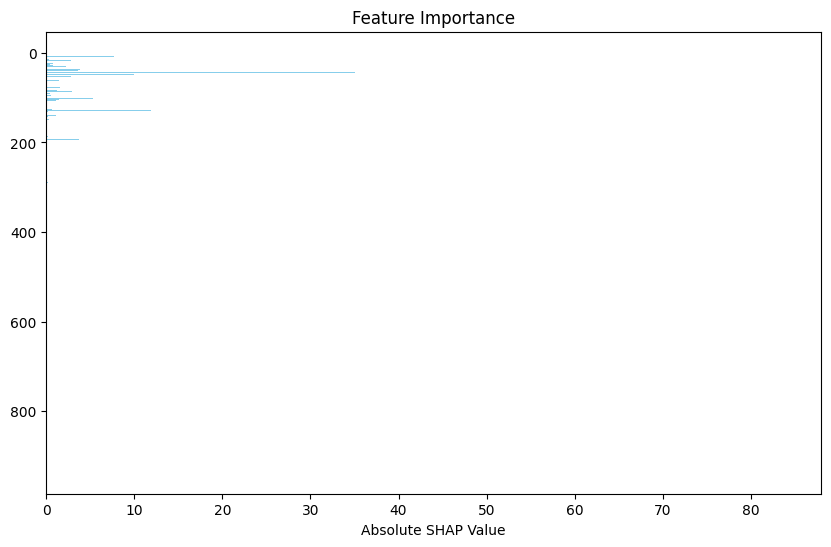

Feature Importance:
     Feature  Importance
4          4   83.769927
109      109   65.067281
23        23   44.724146
44        44   35.083663
29        29   14.036231
..       ...         ...
400      400    0.000000
401      401    0.000000
402      402    0.000000
403      403    0.000000
937      937    0.000000

[938 rows x 2 columns]


In [34]:
# Calculate Shapley values using the shap library
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Compute the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    "Feature": [i for i in range(X_train.shape[1])],
    "Importance": mean_abs_shap_values
}).sort_values(by="Importance", ascending=False)

# Plot the mean absolute SHAP values
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute SHAP Value')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

print("Feature Importance:")
print(importance_df)

In [35]:
important_features = importance_df[importance_df['Importance'] > cut_importance]
important_features

,Feature,Importance
4,4,83.769927
109,109,65.067281
23,23,44.724146
44,44,35.083663
29,29,14.036231
129,129,11.877792
2,2,11.241409
48,48,10.001660
8,8,7.675718
79,79,7.527649


In [36]:
(important_features.mean())[1]

21.189464319921193